In [1]:
!pip install -U spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pyspellchecker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install bs4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# Import Libraries
import pandas as pd
import numpy as np
from pathlib import Path
import textwrap as tw
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import joblib
import re
from bs4 import BeautifulSoup
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import spacy
from spacy.matcher import Matcher
from spacy.tokens import Token
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from collections import Counter
from xgboost import XGBClassifier
from sklearn import metrics
from spellchecker import SpellChecker

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
data_folder = Path('/content/drive/MyDrive/NLP')

In [7]:
!python -m spacy download en_core_web_sm

2022-09-15 05:41:30.866905: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 4.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [8]:
nlp = spacy.load('en_core_web_sm')

**Q1: Load the dataset (1 Point)**                                                          
For this Hw you will usespam dataset from kaggle which can be found from this link. You can download this data and either upload it in google drive or in colab workspace. Load the data in pandas dataframe.

There are only two useful columns. These columns are related to (1) label (ham and spam) and the (2) text of email.

Rename columns as label and message

Find the % ham amd spam in the data.

In [9]:
spam_file = data_folder / 'spam.csv'

In [10]:
# creating Dataframe
spam = pd.read_csv(spam_file, index_col=0,encoding = 'ISO-8859-1')

In [11]:
print(f'Shape of data set is : {spam.shape}')

Shape of data set is : (5572, 4)


In [12]:
spam.head()

,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
v1,,,,
ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [13]:
spam.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5572 entries, ham to ham
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v2          5572 non-null   object
 1   Unnamed: 2  50 non-null     object
 2   Unnamed: 3  12 non-null     object
 3   Unnamed: 4  6 non-null      object
dtypes: object(4)
memory usage: 217.7+ KB


In [14]:
spam.drop(columns = ['Unnamed: 2','Unnamed: 3', 'Unnamed: 4'], inplace=True)
spam.reset_index(inplace=True)
spam.rename(columns={'v1':'label', 'v2':'message'},inplace=True)

In [15]:
spam.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
# Checking for missing values
spam.isna().sum()

label      0
message    0
dtype: int64

In [17]:
# Checking distribution of class labels for train dataset
spam['label'].value_counts(normalize=True)

ham     0.865937
spam    0.134063
Name: label, dtype: float64

In [18]:
# Checking distribution of class labels for train dataset
spam['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [19]:
save_model_folder = Path('/content/drive/MyDrive/NLP/saved_models')

**Q2 : Provide the metric for evaluating model (1 Point)**                       
As you will notice, the  data is highly imbalanced (most messages are labelled as ham and only few are labelled as spam). Always predicting ham will give us very good accuracy (close to 90%). So you need to choose a different metric.

Task: Provde the metric you will choose to evaluate your model. Explain why this is an appropriate metric for this case.

In [20]:
#Using accuracy as the metric is not optimal to making the best prediction especially due to the fact that our data set is imbalanced

#To achieve an optimal result we would like to maximize two components:

#(1) The "True Positive Rate" aka Sensitivity aka Recall. Given by: TP/(TP+FN)

#(2) The Precision - How many of the positive predictions, are in fact correct. Given by: TP/(TP+FP)

#To obtain a balance between both we use F Beta Measure which is given by: (2 x Precision x Recall)/(Precision+Recall)
#F2-measure puts more attention on increasing reacall and minimizing false negatives which is critical for our problem statement given that we would not want to miss any actual spam messages.

In [21]:
# Creating a scorer for F2 score so that we can given an emphases on the minority class predictions i.e higher recall
from sklearn.metrics import fbeta_score, make_scorer
f2score = make_scorer(fbeta_score, beta=2)
f2score

make_scorer(fbeta_score, beta=2)

# Q3 : Classification Pipelines

In the previous lectures you learned Data processing, Featurization such as CountVectorizer, TFIDFVectorizer, and also Feature Engineering.
* You will now use all these technique and create following  classification pipelines

    1. Data Preprocessing + Sparse Embeddings (TF-IDF) + ML Model pipeline
    2. Feature Engineering + ML Model pipeline
    3. Featurization (TF-IDF) + Feature Engineering + ML Model pipeline

**Approach:**

**Use a smaller subset of dataset (recommended 40 %) to evaluate the three pipelines . Based on your analysis (e.g. model score, learning curves) , choose one pipeline from the three. Provde your rational for choosing the pipleine. Train only the final pipeline on complete data.**

**Requirements:** 

1. You will use XgBoost model for the classification. You will need to tune the **XGBoost for imbalanced dataset** (If you have never used XGBoost before , here is the link on XGBoost tutorial for imbalanced data: https://machinelearningmastery.com/xgboost-for-imbalanced-classification/).

2. For feature engineering, you can choose from the examples below. You do not  have to use all of them. You can add other featues as well. Think about what faetures can distinguish a spam from a regular email. Some examples :

>> Count of following  (Nouns, ProperNouns, AUX, VERBS, Adjectives, named entities, spelling mistakes (see the link on how to get spelling mistakes https://pypi.org/project/pyspellchecker/). 

3. For Sparse embeddings you will use **tfidf vectorization**. You need to choose appopriate parameters e.g. min_df, max_df, max_faetures, n-grams etc.). 

In [22]:
spam['label'] = spam['label'].map({'spam':1, 'ham':0}).astype(int)

In [23]:
# Sample 10% of data
spam_smaller = spam.sample(frac=0.1, replace=True, random_state=1)

In [24]:
X = spam_smaller['message'].values
y = spam_smaller['label'].values
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0)
print(f'X_train: {X_train.shape} y_train: {y_train.shape}')
print(f'X_test: {X_test.shape} y_test: {y_test.shape}')

X_train: (417,) y_train: (417,)
X_test: (140,) y_test: (140,)


In [25]:
# Defining Custom Classes

In [26]:
class SpacyPreprocessor(BaseEstimator, TransformerMixin):
    np.random.seed(0)
    def __init__(self, lammetize=True, lower=True, remove_stop=True, 
                 remove_punct=True, remove_email=True, remove_url=True, remove_num=False, stemming = False,
                 add_user_mention_prefix=True, remove_hashtag_prefix=False):
        self.remove_stop = remove_stop
        self.remove_punct = remove_punct
        self.remove_num = remove_num
        self.remove_url = remove_url
        self.remove_email = remove_email
        self.lammetize = lammetize
        self.lower = lower
        self.stemming = stemming
        self.add_user_mention_prefix = add_user_mention_prefix
        self.remove_hashtag_prefix = remove_hashtag_prefix

 # helpfer functions for basic cleaning 

    def basic_clean(self, text):
        
        '''
        This fuction removes HTML tags from text
        '''
        if (bool(BeautifulSoup(text, "html.parser").find())==True):         
            soup = BeautifulSoup(text, "html.parser")
            text = soup.get_text()
        else:
            pass
        return re.sub(r'[\n\r]',' ', text) 

    # helper function for pre-processing with spacy and Porter Stemmer
    
    def spacy_preprocessor(self,texts):

        final_result = []
        nlp = spacy.load('en_core_web_sm', disable=['parser','ner'])
        
        ## Add @ as a prefix so that we can separate the word from its token
        prefixes = list(nlp.Defaults.prefixes)

        if self.add_user_mention_prefix:
            prefixes += ['@']

        ## Remove # as a prefix so that we can keep hashtags and words together
        if self.remove_hashtag_prefix:
            prefixes.remove(r'#')

        prefix_regex = spacy.util.compile_prefix_regex(prefixes)
        nlp.tokenizer.prefix_search = prefix_regex.search

        matcher = Matcher(nlp.vocab)
        if self.remove_stop:
            matcher.add("stop_words", [[{"is_stop" : True}]])
        if self.remove_punct:
            matcher.add("punctuation",[ [{"is_punct": True}]])
        if self.remove_num:
            matcher.add("numbers", [[{"like_num": True}]])
        if self.remove_url:
            matcher.add("urls", [[{"like_url": True}]])
        if self.remove_email:
            matcher.add("emails", [[{"like_email": True}]])
            
        Token.set_extension('is_remove', default=False, force=True)

        cleaned_text = []
        for doc in nlp.pipe(texts,batch_size= 500,disable=['parser','ner'], n_process = 3):
            matches = matcher(doc)
            for _, start, end in matches:
                for token in doc[start:end]:
                    token._.is_remove =True
                    
            if self.lammetize:              
                text = ' '.join(token.lemma_ for token in doc if (token._.is_remove==False))
            elif self.stemming:
                text = ' '.join(PorterStemmer().stem(token.text) for token in doc if (token._.is_remove==False))
            else:
                text = ' '.join(token.text for token in doc if (token._.is_remove==False))
                                   
            if self.lower:
                text=text.lower()
            cleaned_text.append(text)
        return cleaned_text

    def fit(self, X,y=None):
        return self

    def transform(self, X, y=None):
        try:
            if str(type(X)) not in ["<class 'list'>","<class 'numpy.ndarray'>"]:
                raise Exception('Expected list or numpy array got {}'.format(type(X)))
            x_clean = [self.basic_clean(text) for text in X]
            x_clean_final = self.spacy_preprocessor(x_clean)
            return x_clean_final
        except Exception as error:
            print('An exception occured: ' + repr(error))

In [27]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    np.random.seed(0)
    nlp = spacy.load('en_core_web_sm', disable=['parser'])
    spell = SpellChecker()
    def __init__(self, word_count=False, char_count=False, char_count_wo_space=False, 
                 avg_word_length=False, digit_count=False, noun_count= True, propernoun_count=True, 
                 verb_count=True, aux_count= True, adj_count= True, ner_count= True, misspelled_count=True):
        self.word_count = word_count
        self.char_count = char_count
        self.char_count_wo_space = char_count_wo_space
        self.avg_word_length = avg_word_length
        self.digit_count = digit_count
        self.noun_count = noun_count
        self.propernoun_count = propernoun_count
        self.verb_count = verb_count
        self.aux_count = aux_count
        self.adj_count = adj_count
        self.ner_count = ner_count
        self.misspelled_count= misspelled_count
  
    def fit(self, X,y=None):
        return self

    #Useful functions

    def wordCount(self,text):
        return len(text.split())

    def charCount(self,text):
        return len(text)

    def charCountWithoutSpace(self,text):
        count = 0
        for word in text.split():
            count += len(word)
        return count

    def avgWordLength(self,text):
        word_length = 0
        for token in text.split():
            word_length += len(token)
        word_count = len(text.split())
        if word_count == 0:
            return 0
        else:
            return word_length/word_count

    def digitCount(self,text):
        count = 0
        for i in text:
            if i.isdigit():
                count += 1
        return count

    

    def nouncount(self, text):
      doc = nlp(text)
      noun_tokens = [token.text for token in doc if(token.pos_== 'NOUN')]        
      return len(noun_tokens)

    def propernouncount(self, text):
      doc = nlp(text)
      prnoun_tokens = [token.text for token in doc if(token.pos_== 'PROPN')]       
      return len(prnoun_tokens)
    
    def verbcount(self, text):
      doc = nlp(text)
      verb_tokens = [token.text for token in doc if(token.pos_== 'VERB')]         
      return len(verb_tokens)
    
    def auxcount(self, text):
      doc = nlp(text)
      aux_tokens = [token.text for token in doc if(token.pos_== 'AUX')]        
      return len(aux_tokens)

    def adjcount(self, text):
      doc = nlp(text)
      adj_tokens = [token.text for token in doc if(token.pos_== 'ADJ')]        
      return len(adj_tokens)

    def nercount(self, text):
      doc = nlp(text)
      ner = [entity.text for entity in doc.ents]       
      return len(ner)

    def misspelledcount(self,text):
      doc = nlp(text)
      tokens = [token.text for token in doc]
      misspelled_tokens = SpellChecker().unknown(tokens)       
      return len(misspelled_tokens)

    def transform(self, X,y=None):
        try:
            if str(type(X)) not in ["<class 'list'>","<class 'numpy.ndarray'>"]:
                raise Exception('Expected list or numpy array got {}'.format(type(X)))
            final_result = []
            for index,item in enumerate(X):
                res = []
                if self.word_count:
                    res.append(self.wordCount(item))
                if self.char_count:
                    res.append(self.charCount(item))
                if self.char_count_wo_space:
                    res.append(self.charCountWithoutSpace(item))
                if self.avg_word_length:
                    res.append(self.avgWordLength(item))
                if self.digit_count:
                    res.append(self.digitCount(item))
                if self.noun_count:
                    res.append(self.nouncount(item))
                if self.propernoun_count:
                    res.append(self.propernouncount(item))
                if self.verb_count:
                    res.append(self.verbcount(item))
                if self.aux_count:
                    res.append(self.auxcount(item))
                if self.adj_count:
                    res.append(self.adjcount(item))
                if self.ner_count:
                    res.append(self.nercount(item))
                if self.misspelled_count:
                    res.append(self.misspelledcount(item))
                final_result.append(res)
            return np.array(final_result)
        except Exception as error:
            print('An exception occured: ' + repr(error))


In [28]:
class DenseTransformer(TransformerMixin):

  def fit(self, X, y=None, **fit_params):
      return self

  def transform(self, X, y=None, **fit_params):
      return X.todense()

In [29]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 2 plots: the test and training learning curve, the training
    samples vs fit times curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True,
                       random_state=123)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    return plt

In [30]:
# Data Preprocessing + Sparse Embeddings (TF-IDF) + ML Model pipeline --------Pipeline 1

In [31]:
# count examples in each class
counter = Counter(spam_smaller['label'])
counter

Counter({0: 484, 1: 73})

In [32]:
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]

In [33]:
Classifier_1 = Pipeline([('preprocessor', SpacyPreprocessor(remove_stop=False, remove_email=False, remove_url=False )),
                  ('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
                  ('classifier', XGBClassifier(scale_pos_weight=estimate))
                 ])

In [34]:
param_grid_classifier_1 = {'preprocessor__lammetize' : [True, False],
                'vectorizer__max_features': [100, 500, None],
                'vectorizer__max_df': [0.2, 0.8, 1],
                'vectorizer__min_df': [0.01,0.5, 1]
                }

In [35]:
# Using Gridserach to  fine tune hyperparameters using cross validation
# As we have imbalanced data set, we will use scoring method of f2score.
grid_classifier_1 = GridSearchCV(estimator=Classifier_1, param_grid=param_grid_classifier_1, cv = 2, scoring= f2score, n_jobs= 1, verbose = 4)

In [36]:
# Fit the model on training data
grid_classifier_1.fit(X_train, y_train)

Fitting 2 folds for each of 54 candidates, totalling 108 fits
[CV 1/2] END preprocessor__lammetize=True, vectorizer__max_df=0.2, vectorizer__max_features=100, vectorizer__min_df=0.01;, score=0.542 total time=   6.7s
[CV 2/2] END preprocessor__lammetize=True, vectorizer__max_df=0.2, vectorizer__max_features=100, vectorizer__min_df=0.01;, score=0.625 total time=   6.8s
[CV 1/2] END preprocessor__lammetize=True, vectorizer__max_df=0.2, vectorizer__max_features=100, vectorizer__min_df=0.5;, score=nan total time=   3.6s
[CV 2/2] END preprocessor__lammetize=True, vectorizer__max_df=0.2, vectorizer__max_features=100, vectorizer__min_df=0.5;, score=nan total time=   3.4s
[CV 1/2] END preprocessor__lammetize=True, vectorizer__max_df=0.2, vectorizer__max_features=100, vectorizer__min_df=1;, score=0.565 total time=   4.5s
[CV 2/2] END preprocessor__lammetize=True, vectorizer__max_df=0.2, vectorizer__max_features=100, vectorizer__min_df=1;, score=0.551 total time=   3.4s
[CV 1/2] END preprocessor_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
48 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 355, in _fit
    **fit_params_steps[name],
  File "/usr/local/lib/python3.7/dist-packages/joblib/memory.py", lin

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        SpacyPreprocessor(remove_email=False,
                                                          remove_stop=False,
                                                          remove_url=False)),
                                       ('vectorizer',
                                        TfidfVectorizer(token_pattern='[\\S]+')),
                                       ('classifier',
                                        XGBClassifier(scale_pos_weight=6.63013698630137))]),
             n_jobs=1,
             param_grid={'preprocessor__lammetize': [True, False],
                         'vectorizer__max_df': [0.2, 0.8, 1],
                         'vectorizer__max_features': [100, 500, None],
                         'vectorizer__min_df': [0.01, 0.5, 1]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=4)

In [37]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_1.best_score_))
print("\nBest parameters: ", grid_classifier_1.best_params_)
print("\nBest Estimator: ", grid_classifier_1.best_estimator_)

Best cross-validation score: 0.65

Best parameters:  {'preprocessor__lammetize': True, 'vectorizer__max_df': 0.8, 'vectorizer__max_features': 100, 'vectorizer__min_df': 0.01}

Best Estimator:  Pipeline(steps=[('preprocessor',
                 SpacyPreprocessor(remove_email=False, remove_stop=False,
                                   remove_url=False)),
                ('vectorizer',
                 TfidfVectorizer(max_df=0.8, max_features=100, min_df=0.01,
                                 token_pattern='[\\S]+')),
                ('classifier',
                 XGBClassifier(scale_pos_weight=6.63013698630137))])


In [38]:
print('Train score: {:.4f}'.format(grid_classifier_1.score(X_train, y_train)))
print('Test score: {:.4f}'.format(grid_classifier_1.score(X_test, y_test)))

Train score: 0.9962
Test score: 0.7071


In [39]:
file_model_sparse_embed = save_model_folder / 'sparse_embed_model.pkl'

In [41]:
joblib.dump(grid_classifier_1.best_estimator_, file_model_sparse_embed)

['/content/drive/MyDrive/NLP/saved_models/sparse_embed_model.pkl']

In [42]:
loaded_model_sparse_embed = joblib.load(file_model_sparse_embed)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

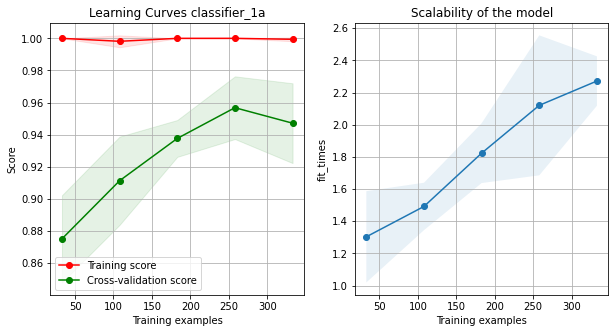

In [43]:
# plot learning curces
plot_learning_curve(loaded_model_sparse_embed, 'Learning Curves classifier_1a', X_train, y_train)

In [44]:
#Featurization (TF-IDF) + Feature Engineering + ML Model pipeline----Pipeline 2

In [45]:
vectorization = Pipeline([ ('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+")),
                         ])                        
feature_engineering = FeatureEngineering()
combined_features = FeatureUnion([("vec", vectorization), ("fe", feature_engineering)])

In [46]:
classifier_2 = Pipeline([('cf', combined_features),
                  ('classifier', XGBClassifier(scale_pos_weight=estimate)),
                 ])

In [47]:

param_grid_classifier_2 = {'cf__vec__vectorizer__max_features': [100, 500],
                           'cf__vec__vectorizer__max_df': [0.2, 0.6],
                           'cf__vec__vectorizer__min_df': [0.01, 0.5]}

In [48]:
grid_classifier_2 = GridSearchCV(estimator=classifier_2, param_grid=param_grid_classifier_2, cv = 2,scoring = f2score, n_jobs= -1, verbose = 4 )

In [49]:
grid_classifier_2.fit(X_train, y_train)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
8 fits failed out of a total of 16.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 355, in _fit
    **fit_params_steps[name],
  File "/usr/local/lib/python3.7/dist-packages/joblib/memory.py", line 3

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('cf',
                                        FeatureUnion(transformer_list=[('vec',
                                                                        Pipeline(steps=[('vectorizer',
                                                                                         TfidfVectorizer(token_pattern='[\\S]+'))])),
                                                                       ('fe',
                                                                        FeatureEngineering())])),
                                       ('classifier',
                                        XGBClassifier(scale_pos_weight=6.63013698630137))]),
             n_jobs=-1,
             param_grid={'cf__vec__vectorizer__max_df': [0.2, 0.6],
                         'cf__vec__vectorizer__max_features': [100, 500],
                         'cf__vec__vectorizer__min_df': [0.01, 0.5]},
             scoring=make_scorer(fbeta_score, beta=2), verbo

In [50]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_2.best_score_))
print("Best parameters: ", grid_classifier_2.best_params_)

Best cross-validation score: 0.58
Best parameters:  {'cf__vec__vectorizer__max_df': 0.6, 'cf__vec__vectorizer__max_features': 100, 'cf__vec__vectorizer__min_df': 0.01}


In [51]:
print('Train score: {:.4f}'.format(grid_classifier_2.score(X_train, y_train)))
print('Test score: {:.4f}'.format(grid_classifier_2.score(X_test, y_test)))

Train score: 1.0000
Test score: 0.7767


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

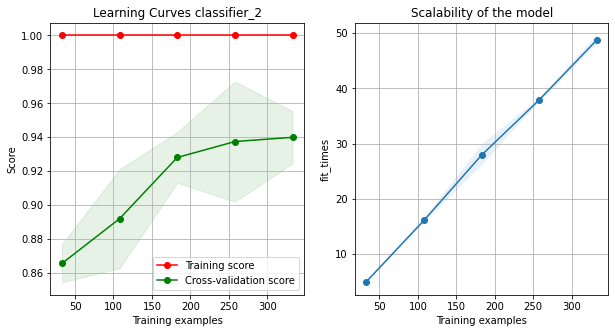

In [52]:
# plot learning curces
# This cell can took upto 30 minutes to run
plot_learning_curve(grid_classifier_2.best_estimator_, 'Learning Curves classifier_2', X_train, y_train)

In [53]:
#Feature Engineering + ML Model pipeline ----------- Pipeline 3

In [54]:
classifier_3 = Pipeline([('fe', FeatureEngineering()),
                  ('classifier', XGBClassifier(scale_pos_weight=estimate))    ])

In [55]:
param_grid_classifier_3 = {'classifier__max_depth' : [3,4,5]}

In [58]:
grid_classifier_3 = GridSearchCV(estimator=classifier_3, param_grid=param_grid_classifier_3, scoring = f2score, cv = 3,  n_jobs= 1, verbose = 4)

In [59]:
grid_classifier_3.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END ...........classifier__max_depth=3;, score=0.674 total time= 1.0min
[CV 2/3] END ...........classifier__max_depth=3;, score=0.427 total time=  59.2s
[CV 3/3] END ...........classifier__max_depth=3;, score=0.714 total time=  59.4s
[CV 1/3] END ...........classifier__max_depth=4;, score=0.682 total time= 1.0min
[CV 2/3] END ...........classifier__max_depth=4;, score=0.449 total time=  59.6s
[CV 3/3] END ...........classifier__max_depth=4;, score=0.677 total time=  59.7s
[CV 1/3] END ...........classifier__max_depth=5;, score=0.682 total time=  59.6s
[CV 2/3] END ...........classifier__max_depth=5;, score=0.443 total time= 1.0min
[CV 3/3] END ...........classifier__max_depth=5;, score=0.684 total time= 1.0min


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('fe', FeatureEngineering()),
                                       ('classifier',
                                        XGBClassifier(scale_pos_weight=6.63013698630137))]),
             n_jobs=1, param_grid={'classifier__max_depth': [3, 4, 5]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=4)

In [60]:
print("Best cross-validation score: {:.2f}".format(grid_classifier_3.best_score_))
print("\nBest parameters: ", grid_classifier_3.best_params_)
print("\nBest Estimator: ", grid_classifier_3.best_estimator_)

Best cross-validation score: 0.61

Best parameters:  {'classifier__max_depth': 3}

Best Estimator:  Pipeline(steps=[('fe', FeatureEngineering()),
                ('classifier',
                 XGBClassifier(scale_pos_weight=6.63013698630137))])


In [61]:
print('Train score: {:.4f}'.format(grid_classifier_3.score(X_train, y_train)))
print('Test score: {:.4f}'.format(grid_classifier_3.score(X_test, y_test)))

Train score: 0.9239
Test score: 0.8261


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

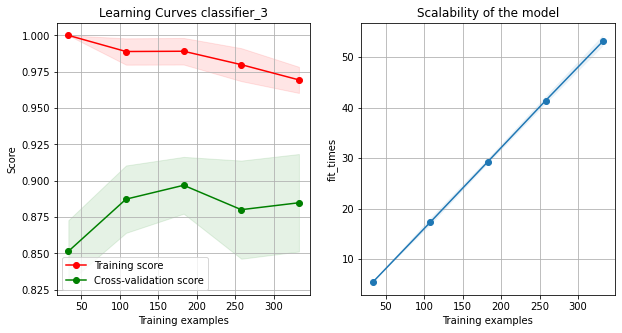

In [62]:
# plot learning curces
plot_learning_curve(grid_classifier_3.best_estimator_, 'Learning Curves classifier_3', X_train, y_train)